In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import re
import multiprocessing
from collections import Counter
import itertools
import json
from IPython.display import display as disp

import numpy as np
# import bottleneck as bn
import pandas as pd
import networkx as nx
# import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
%matplotlib inline
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]
mpl.rcParams['text.usetex'] = False

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, plotting, modeleval

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

# import pixiedust

In [2]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.decomposition import PCA 
from sklearn import model_selection

# The data

`x` indicates activity, partitioned into eight quarters, for the four channels ABCD.
`y` indicates movement.

In [3]:
data_path = '../../allan_data/DataPredictMovement_half.p'

In [4]:
x, y = np.load(data_path) 

Plotting the average value of the `x`-vectors, we see that every first quarter of an lower amound of activity. This could reflect human behaviour, because events often start on an hourly basis, or it could be a binning problem.

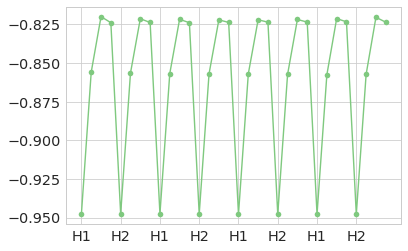

In [5]:
fig, ax = plt.subplots()
ax.plot(x.mean(axis=0), 'o-', c=colorcycle[0])
# xticks = np.array([np.array([0, 3]) + (i*4) for i in range(0, 8)]).ravel()
xticks = np.arange(0, 32, 4)
ax.set_xticks(xticks)
ax.set_xticklabels(["H1", "H2"]*4);

Below is the average of the four quarters in an hour. The same effect with low counts in the first quarter is seen.

In [6]:
means = np.zeros(4)
base_idx = np.arange(0, 32, 4)
for i in range(4):
    idx = base_idx + i
    icut = min(base_idx[-1]+i, x.shape[1])
    idx = idx[idx <= icut]
    arr = x[:, base_idx + i]
    means[i] = arr.mean()
    print("%.3f" % means[i])


-0.948
-0.857
-0.821
-0.824


Heatmap of the correlation shows the same pattern... perhaps a dimmensionality reduction is in order, since the intrinsic dimmension of the data might be quite a bit smaller than the current dimmensionalty.

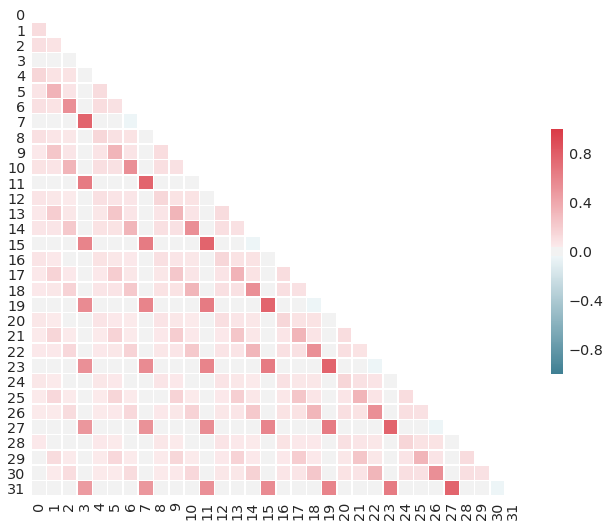

In [7]:
sample_idx = np.random.choice(range(len(y)), len(y)//25) 
dfs = pd.DataFrame(x[sample_idx, :])
corr = dfs.corr() 

with sns.axes_style("white"):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}) 

In [8]:
pca = PCA() 
pca.fit(x)
xx = pca.transform(x)

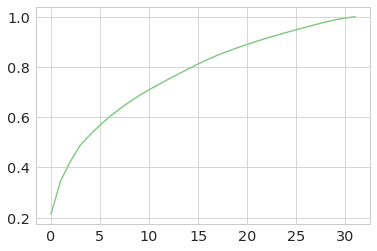

In [9]:
fig, ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_.cumsum())

In [10]:
lrc_cv = LogisticRegressionCV(n_jobs=42, scoring='accuracy', penalty='l2', cv=5)

In [11]:
x.shape

(6549096, 32)

In [12]:
y.shape

(6549096,)

In [13]:
lrc_cv.fit(x[:10000, :], y[:10000])

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=42, penalty='l2', random_state=None,
           refit=True, scoring='accuracy', solver='lbfgs', tol=0.0001,
           verbose=0)

In [14]:
yhat_logRe = lrc_cv.predict_proba(x)

In [15]:
yhat_logRe.shape

(6549096, 2)

In [16]:
yhat_logRe[:15, :]

array([[0.94836759, 0.05163241],
       [0.94816882, 0.05183118],
       [0.975408  , 0.024592  ],
       [0.96692462, 0.03307538],
       [0.9597784 , 0.0402216 ],
       [0.96692462, 0.03307538],
       [0.96692462, 0.03307538],
       [0.91434217, 0.08565783],
       [0.96692462, 0.03307538],
       [0.90047049, 0.09952951],
       [0.5178281 , 0.4821719 ],
       [0.96692462, 0.03307538],
       [0.48645802, 0.51354198],
       [0.96692462, 0.03307538],
       [0.96692462, 0.03307538]])

In [17]:
yy = y.copy() 
yy[yy == -1] = 0
yy.shape

(6549096,)

In [18]:
yhat_logRe.shape

(6549096, 2)

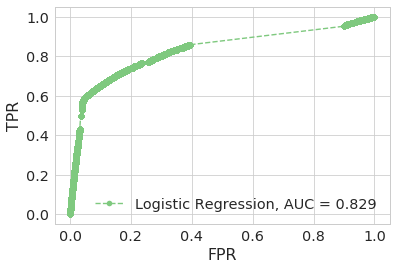

In [19]:
fpr, tpr, thr = metrics.roc_curve(y, yhat_logRe[:, 1])

fig, ax = plt.subplots()
ax.plot(fpr, tpr, 'o--', label=f'Logistic Regression, AUC = {metrics.auc(fpr, tpr):.3f}')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.legend(loc='lower right')

In [20]:
N1 = 450
sample_idx = np.random.choice(range(len(y)), N1)
x2 = x[sample_idx, :]
y2 = y[sample_idx] 

In [21]:
svc = SVC(probability=True) 

In [22]:
svc.fit(x2, y2)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
N2 = 1500
sample_idx3 = np.array(sorted(set(np.random.choice(range(len(y)), N2)) - set(sample_idx)))

In [24]:
x3 = x[sample_idx3, :]
y3 = y[sample_idx3]

In [25]:
yhat_svc = svc.predict_proba(x3)

In [26]:
fpr, tpr, thr = metrics.roc_curve(y3, yhat_svc[:, 1])
auc = metrics.auc(fpr, tpr)
auc

0.7923387597553888

AUC is 0.792


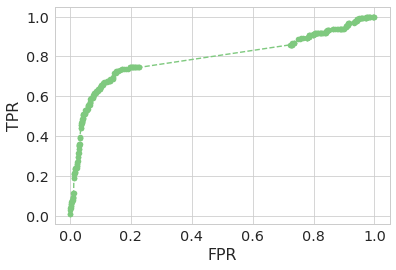

In [27]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, 'o--')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
auc = metrics.auc(fpr, tpr)
print(f"AUC is {auc:.3f}")

In [28]:
N4 = 8000
sample_idx4 = np.random.choice(range(len(y)), N4)
x4 = x[sample_idx4, :]
y4 = y[sample_idx4]

In [29]:
tuned_parameters = [{'kernel': ['rbf', 'linear', 'poly'],
                     'gamma': np.array([1e-2, 1e-2, 1e-3, 1e-4, 1e-5]),
                     'C': np.array([0.01, 0.1, 1, 10, 100, 1000])}] 
print(tuned_parameters) 

[{'kernel': ['rbf', 'linear', 'poly'], 'gamma': array([1.e-02, 1.e-02, 1.e-03, 1.e-04, 1.e-05]), 'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}]


In [31]:
# perf = modeleval.gridsearchCrossVal(x4, y4, SVC, tuned_parameters=tuned_parameters, score='roc_auc', n_jobs=40)
n_splits = 5
score = 'accuracy'
test_size = 0.3
subgrid_points = 20
perf_df, perf_df_sub, perf_eval_df = modeleval.fitAndEvalueateModel(x4, y4,
                                                                    SVC(probability=True),
                                                                    tuned_parameters, score, n_splits,
                                                                    test_size, subgrid_points)

In [32]:
perf_df 

,accuracy,best_params
fold,,
0,0.924107,"((C, 0.01), (gamma, 0.01), (kernel, linear))"
1,0.922679,"((C, 0.01), (gamma, 0.01), (kernel, linear))"
2,0.925179,"((C, 0.01), (gamma, 0.01), (kernel, linear))"
3,0.920357,"((C, 0.01), (gamma, 0.01), (kernel, linear))"
4,0.923036,"((C, 0.01), (gamma, 0.01), (kernel, linear))"


In [33]:
perf_df_sub

,accuracy,best_params
fold,,
0,0.92125,"((C, 0.011421052631578946), (gamma, 0.001), (k..."
1,0.920357,"((C, 0.006210526315789474), (gamma, 0.001), (k..."
2,0.925357,"((C, 0.006210526315789474), (gamma, 0.001), (k..."
3,0.925,"((C, 0.006210526315789474), (gamma, 0.001), (k..."
4,0.924643,"((C, 0.006210526315789474), (gamma, 0.001), (k..."


In [34]:
perf_eval_df

,AUC,accuracy
fold,,
0,0.772663,0.0566667
1,0.787948,0.0545833
2,0.751411,0.0558333
3,0.723333,0.0508333
4,0.782923,0.0525


In [35]:
x4_tr, x4_te, x4_va, y4_tr, y4_te, y4_va = modeleval.train_test_validate_split(x4, y4, train_size=0.55,
                                                                               test_size=0.30, validate_size=0.15)

In [ ]:
svc_gs = model_selection.GridSearchCV(SVC(), tuned_parameters, scoring='roc_auc', n_jobs=42)

In [ ]:
svc_gs.fit(x4_tr, y4_tr)

In [ ]:
svc_gs.predict_proba(x4_te, y4_te)

In [ ]:
params = svc_gs.estimator.get_params()
params['probability'] = True
svc = SVC(**params) 

In [ ]:
svc.fit(x4_tr, y4_tr)

In [ ]:
yhat = svc.predict_proba(x4_te)

In [ ]:
yhat = yhat[:, 1]

In [ ]:
yy = y.copy()
yy[yy == -1] = 0

In [ ]:
fpr, tpr, thr = metrics.roc_curve(y4_te, yhat)
auc = metrics.auc(fpr, tpr)
auc

fig, ax = plt.subplots()
ax.plot(fpr, tpr, 'o--')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
auc = metrics.auc(fpr, tpr)
print(f"AUC is {auc:.3f}")